# CS530 HW8

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

#### Question 1. (4 points)

a. For classification trees, implement three functions to calculate the (1) cross-entropy, (2) Gini index, and (3) misclassification error. Assume binary classification (labels are 0’s and 1’s). The functions takes p_1, the probability of a record belong to class k=1, as input.

In [2]:
def cal_cross_entropy(p_1):
    cross_entropy = - (p_1 * math.log(p_1) + p_1 * math.log(p_1))
    return cross_entropy

def cal_gini_index(p_1):
    gini_index = p_1 * (1-p_1) + (1-p_1) * p_1
    return gini_index

def cal_misclassification_error(p_1):
    mc_error = 1 - p_1
    return mc_error

b. Apply the three functions you implemented in 1a on the training test (train.csv) of the heart-disease dataset. Choose the 'age' variable as the root node. Use each value in the 'age' variable as the splitting value. Plot the cross entropy, Gini index, and misclassification error over age on the two child nodes after splitting.

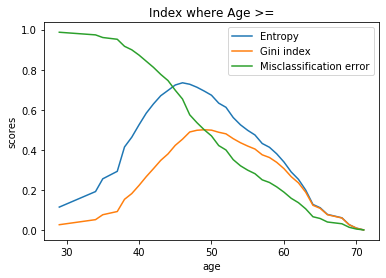

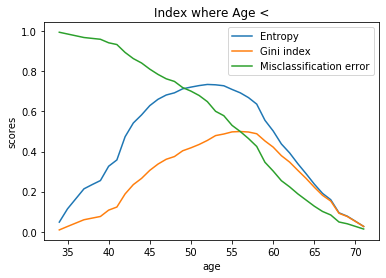

In [3]:
train = pd.read_csv("train.csv")

train.drop(train.columns[train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


train.head()
ages = train.age.unique()
crossEntropies = []
giniIndexes = []
mcErrors = []
leftIndexes = []
rightIndexes = []
splits = []

for i in range(len(ages)):
    age = train.age
    split = ages[i]
    splits.append(split)
    
    lessThan = age[age < split]
    greaterOrEqual = age[age >= split]
    leftIndex = lessThan.count()/age.count()
    rightIndex = greaterOrEqual.count()/age.count()
    splits.sort()
    rightIndexes.append(rightIndex)
    leftIndexes.append(leftIndex)
    
rightIndexes.sort()
leftIndexes.sort()

for p in rightIndexes:
    crossEntropies.append(cal_cross_entropy(p))
    giniIndexes.append(cal_gini_index(p))
    mcErrors.append(cal_misclassification_error(p))
    
plt.plot(splits, crossEntropies, label= "Entropy")
plt.plot(splits, giniIndexes, label= "Gini index")
plt.plot(splits, mcErrors, label= "Misclassification error") 
plt.legend(loc='upper right')
plt.xlabel("age")

plt.ylabel("scores")
plt.title("Index where Age >=")


plt.show()

'''
plt.plot(rightIndexes, crossEntropies, label= "Entropy")
plt.plot(rightIndexes, giniIndexes, label= "Gini index")
plt.plot(rightIndexes, mcErrors, label= "Misclassification error")
plt.legend(loc='upper right')
plt.xlabel("p")
plt.ylabel("scores")
plt.show()
'''

crossEntropies = []
giniIndexes = []
mcErrors = []

for p in leftIndexes:
    if p == 0:
        i = leftIndexes.index(0)
        splits.pop(i)
    else:
        crossEntropies.append(cal_cross_entropy(p))
        giniIndexes.append(cal_gini_index(p))
        mcErrors.append(cal_misclassification_error(p))
    
plt.plot(splits, crossEntropies, label= "Entropy")
plt.plot(splits, giniIndexes, label= "Gini index")
plt.plot(splits, mcErrors, label= "Misclassification error")
plt.legend(loc='upper right')
plt.xlabel("age")
plt.ylabel("scores")
plt.title("Index where Age <")



plt.show()
    

c. Discuss what you find in 1b. What age would you choose for the splitting value?

By looking at the graphs, it looks like we should split at around age 50 to mid 50s. On both nodes/graphs, the gini index has its highest score right around this age. Same with the entropy.  We want to split on a high gini index.

#### Question 2. (3 points)

a. Implement a function to carry out the regression tree algorithm using the greedy approach. This implementation assumes the tree only splits twice. The function takes inputs X_train, y_train, and X_test, and return a prediction y_pred for X_test.

In [4]:
#splits tree based on RSS
def splitTree(df):
    numRows = df.shape[0]
    
    allRSS = []
    columnNum = 0
    
    for col in df:
        if columnNum == 3:
            break
            
        df = df.sort_values(by=[col])
        splits = []
        RSSVals = []
        
        for i in range(numRows):
            lessThanMean = df[:i].iloc[:,3].mean()
            greaterThanMean = df[i:].iloc[:,3].mean()
        
            RSSLeftNode = 0
            RSSRightNode = 0
            
            for j in range(0,i):
                y = df.iat[j,3]
                RSSLeftNode += (y - lessThanMean)**2
                
            for j in range(i,numRows):
                y = df.iat[j,3]
                RSSRightNode += (y - greaterThanMean)**2
                
            RSSVals.append(RSSLeftNode + RSSRightNode)
            
        df['RSS {}'.format(col)] = RSSVals 
        columnNum += 1

    RSSmins = [df.iloc[:,4].min(), df.iloc[:,5].min(), df.iloc[:,6].min()]
    
    featureToSplit = RSSmins.index(min(RSSmins))
    splitValue = float(df[df.iloc[:,featureToSplit + 4] == min(RSSmins)].iloc[:,featureToSplit].to_string(index=False))
    return featureToSplit, splitValue

In [5]:
def regression_tree(X_train, y_train, X_test):
    
    df = pd.DataFrame(X_train, columns = ['F1', 'F2', 'F3']) 
    df['Y'] = y_train 
    
    featureToSplit, splitValue= splitTree(df)
    colname = df.columns[featureToSplit]


    dfTest = pd.DataFrame(X_test, columns = ['F1', 'F2', 'F3'])

    dfTest1 = dfTest[dfTest[colname] >= splitValue]
    dfTest2 = dfTest[dfTest[colname] < splitValue]


    df1 = df[df[colname] >= splitValue].sort_values(by=[colname])
    df2 = df[df[colname] < splitValue].sort_values(by =[colname])

    featureToSplit1, splitValue1 = splitTree(df1)
    colname1 = df1.columns[featureToSplit1]

    featureToSplit2, splitValue2 = splitTree(df2)
    colname2 = df2.columns[featureToSplit2]

    #Prints out the structure of the reegression tree
    print("REGRESSION TREE")
    print()
    print("Root Node: ", colname)
    print("split {} < {}       {} >= {}\n".format(colname, splitValue, colname, splitValue))
    print()
    print("ChildNode where {} >= {}:".format(colname, splitValue))
    print("Splits on {}".format(colname1))
    print("Split {} < {}        {} >= {}\n".format(colname1, splitValue1, colname1, splitValue1))
    print()
    print("ChildNode where {} < {}:".format(colname, splitValue))
    print("Splits on {}".format(colname2))
    print("Split {} < {}        {} >= {}\n".format(colname2, splitValue2, colname2, splitValue2))


    #make predictions on test set by getting average values of y in regression tree from training set
    df10 = df1[df1[colname1] >= splitValue1]
    dfTest10 = dfTest1[dfTest1[colname1] >= splitValue1]
    dfTest10['y_pred'] = df10.iloc[:,3].mean()

    df11 = df1[df1[colname1] < splitValue1]
    dfTest11 = dfTest1[dfTest[colname1] < splitValue1]
    dfTest11['y_pred'] = df11.iloc[:,3].mean()


    df20 = df2[df2[colname2] >= splitValue2]
    dfTest20 = dfTest2[dfTest2[colname2] >= splitValue2]
    dfTest20['y_pred'] = df20.iloc[:,3].mean()

    df21 = df2[df2[colname2] < splitValue2]
    dfTest21 = dfTest2[dfTest2[colname2] < splitValue2]
    dfTest21['y_pred'] = df21.iloc[:,3].mean()


    #concatenate and sort based on index all child nodes and get the y_preds
    result = pd.concat([dfTest10, dfTest11, dfTest20, dfTest21]).sort_index()
    y_pred = result['y_pred'].to_numpy()


    print("Y_PRED: ", y_pred)

    return y_pred



b. Use the function you implemented in 2a to predict on the synthetic data below.

In [6]:
# make a linearly separable dataset
X, y = make_regression(n_samples=1000,
                       n_features=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
pd.options.mode.chained_assignment = None

y_pred = regression_tree(X_train, y_train, X_test)


REGRESSION TREE

Root Node:  F2
split F2 < 0.085431       F2 >= 0.085431


ChildNode where F2 >= 0.085431:
Splits on F2
Split F2 < 1.393708        F2 >= 1.393708


ChildNode where F2 < 0.085431:
Splits on F2
Split F2 < -1.063717        F2 >= -1.063717

Y_PRED:  [ -37.26735022  -37.26735022   57.7894473  -132.89132668   57.7894473
   57.7894473   -37.26735022 -132.89132668   57.7894473    57.7894473
   57.7894473   -37.26735022   57.7894473  -132.89132668   57.7894473
   57.7894473   -37.26735022   57.7894473   -37.26735022 -132.89132668
  -37.26735022  -37.26735022  167.46460796   57.7894473   167.46460796
   57.7894473   -37.26735022  167.46460796   57.7894473  -132.89132668
  -37.26735022  -37.26735022  -37.26735022  -37.26735022   57.7894473
 -132.89132668   57.7894473   -37.26735022  -37.26735022  -37.26735022
 -132.89132668  167.46460796  -37.26735022   57.7894473    57.7894473
  -37.26735022   57.7894473   -37.26735022   57.7894473   -37.26735022
   57.7894473   167.46460796   57

/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [7]:
# Your code goes here

c. Do you think this implementation of the regression tree is a good model for this dataset? Explain.


In order for this implementation to be a good model for this dataset, it would need to not be cut off at 2 levels of splitting. With only 2 splits, we are left with only 4 child nodes, and thus 4 y predictions. These y_preds are very distinct and far awart form each other which would indicicatee that theree are a lot more y values that are not covered- thus showing that our y predictions are probably not very accuratee. We would need more splits, which would allow for more accuracy and for more featurees to be plit on.

#### Question 3. (3 points)

a. Use the scikit-learn package to run Bagging and Random Forest on the heart-disease dataset and predict on its test set. Use cross-validation to find the best parameters for these algorithms.

In [8]:
# Your code goes here
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from warnings import simplefilter


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.drop(train.columns[train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
test.drop(test.columns[test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


X_train = train.drop(['target'], axis = 1)
y_train = train.target

X_test = test.drop(['target'], axis = 1)
y_test = test.target

clfRF = RandomForestClassifier(max_depth = 2, random_state = 0)
clfRF.fit(X_train, y_train)
zeros = np.zeros(14)
print("PREDICTIONS WITH RANDOM FOREST:\n", clfRF.predict(X_test))
print("AUC: ", metrics.accuracy_score(y_test, clfRF.predict(X_test)))


scores = cross_val_score(clfRF, X_train, y_train, cv=5)
print("CROSS VAL:", scores)
print()

clfBC = BaggingClassifier(base_estimator = SVC(), n_estimators = 10, random_state = 0)
clfBC.fit(X_train,y_train)
print("PREDICTIONS WITH BAGGING:\n", clfBC.predict(X_test))
print("AUC: ", metrics.accuracy_score(y_test, clfBC.predict(X_test)))
scores = cross_val_score(clfBC, X_train, y_train, cv=5)
print("CROSS VAL", scores)


PREDICTIONS WITH RANDOM FOREST:
 [1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0
 0 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1
 1 1]
AUC:  0.8421052631578947
CROSS VAL: [0.80851064 0.80434783 0.84444444 0.75555556 0.73333333]

PREDICTIONS WITH BAGGING:
 [0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1]
AUC:  0.631578947368421


/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: 

CROSS VAL [0.5106383  0.5        0.51111111 0.48888889 0.53333333]


/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/emilydaskas/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/emilydaskas/opt/an

b. On the same axes, plot the ROC curves for the two algorithms with the best parameters that you found in 3a. Annotate their AUC values and compare their performance. 

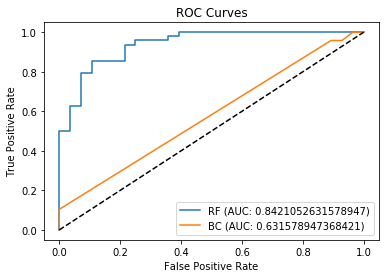

In [9]:
# Your code goes here
from sklearn.metrics import roc_curve

y_pred_RF = clfRF.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_RF)
plt.plot(fpr, tpr, label='RF (AUC: {})'.format(metrics.accuracy_score(y_test, clfRF.predict(X_test))))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')

y_pred_BC = clfBC.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_BC)
plt.plot(fpr, tpr, label='BC (AUC: {})'.format(metrics.accuracy_score(y_test, clfBC.predict(X_test))))
plt.plot([0,1],[0,1], 'k--')
plt.legend(loc = "lower right")
plt.show()


c. Explain your results in 3b. Why might the results vary across algorithms?

The reason that the results vary across the algorithsm, scecifically that the AUC is more accurate for Random Forest is that RF is very similar to bagging, but it has an improvement. The improvement is that tress can only be split on a random subset of the predictors, thus creating more decorrelated treees that better search potential splits in the feature space. This also allows for better splits to be discovered later down the road. This leads to variances and a higher AUC.